In [42]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
import scipy.io as spio
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
def describe_organise_data(mat):
    print("The keys of this data dictionary for this ppt are :", mat.keys())
    triggers = mat['trig']
    fs = mat['fs']
    eeg_data = mat['y']
    print("There are ", len(triggers), " triggers") 
    print("sampling frequency is ", mat['fs'])
    print("Length of data set is ", len(eeg_data))
    return triggers, fs, eeg_data

In [3]:
def format_data(triggers, fs, eeg_data):
    v=np.asarray(triggers)
    indices = np.where(np.diff(v,prepend=np.nan))[0] 

    listvalues = []
    listclasses = []
    ind = 0
    
    for ind in range(0, len(indices)-1):
        listclasses.append(triggers[indices[ind]]) # means we know which class each block relates to
        listvalues.append(eeg_data[indices[ind]:indices[ind+1]]) # gets the block as a subset
         
    left_class = []
    left_value = []
    right_class = []
    right_value = []
    for i,x in enumerate(listclasses):
        if x == 1:
            left_class.append(listclasses[i])
            left_value.append(listvalues[i])
        elif x == -1:
            right_class.append(listclasses[i])
            right_value.append(listvalues[i])
        
 
    left_data = np.array([np.array(x) for x in left_value])
    right_data = np.array([np.array(x) for x in right_value])
    left_labels = np.ones(left_data.shape[0])
    right_labels = np.zeros(right_data.shape[0]) - 1
    
    data = np.concatenate((left_data,right_data))
    labels = np.concatenate((left_labels,right_labels))
    return data,labels

In [33]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap=plt.cm.Blues, save_name=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_name:
        plt.savefig(save_name)
    plt.show()

In [43]:
def trad_ML_training(sub, con, clf, train_x, test_x, train_y, test_y, cv_num=10):
    # Dictionary to store accuracy scores for each classifier
    acc_scores = {}
    classification_reports = {}
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Perform 10-fold cross-validation and get accuracy scores for each classifier
    for name, classifier in tqdm(clf.items(), desc="Classifiers"):
        # Fit the classifier to the training data
        classifier.fit(train_x, train_y)

        # Make predictions on the test data
        pred = classifier.predict(test_x)

        # Calculate accuracy on test data
        acc = classifier.score(test_x, test_y)
        print(f"{name} Accuracy:", acc)
        
        # Generate classification report
        report = classification_report(test_y, pred)
        classification_reports[name] = report

        # Perform 10-fold cross-validation and get accuracy scores
        cv_scores = cross_val_score(classifier, train_x, train_y, cv=cv_num)
        acc_scores[name] = cv_scores.mean()

        # Export cross-validation results to CSV
        cv_results = pd.DataFrame({"Fold": range(1, cv_num + 1), "Accuracy": cv_scores})
        cv_results.to_csv(f"P{sub}_{con}_{name}_cross_validation_results.csv", index=False)

        # Plot cross-validation results
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, cv_num + 1), cv_scores, marker='o')
        plt.title(f"{name} Cross-Validation Results")
        plt.xlabel("Fold")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()
        plt.savefig(f"P{sub}_{con}_{name}_cross_validation_plot.png")
        plt.close()

        # Plot and save confusion matrix for test set
        plot_confusion_matrix(test_y, pred, title=f"{name} Confusion Matrix (Test Set)", save_name=f"P{sub}_{con}_{name}_confusion_matrix_test.png")

        # Perform cross-validation predictions
        cv_preds = cross_val_predict(classifier, train_x, train_y, cv=cv_num)

        # Plot and save confusion matrix for cross-validation
        plot_confusion_matrix(train_y, cv_preds, title=f"{name} Confusion Matrix (Cross-Validation)", save_name=f"P{sub}_{con}_{name}_confusion_matrix_cv.png")

    return acc_scores, classification_reports

In [28]:
# def trad_ML_training(sub, con, clf, train_x, test_x, train_y, test_y, cv_num=10):
#     # Dictionary to store accuracy scores for each classifier
#     acc_scores = {}
#     classification_reports = {}
#     warnings.filterwarnings("ignore", category=UserWarning)
    
#     # Perform 10-fold cross-validation and get accuracy scores for each classifier
#     for name, classifier in tqdm(clf.items(), desc="Classifiers"):
#         # Fit the classifier to the training data
#         classifier.fit(train_x, train_y)

#         # Make predictions on the test data
#         pred = classifier.predict(test_x)

#         # Calculate accuracy on test data
#         acc = classifier.score(test_x, test_y)
#         print(f"{name} Accuracy:", acc)
        
#         # Generate classification report
#         report = classification_report(test_y, pred)
#         classification_reports[name] = report

#         # Perform 10-fold cross-validation and get accuracy scores
#         cv_scores = cross_val_score(classifier, train_x, train_y, cv=cv_num)
#         acc_scores[name] = cv_scores.mean()

#         # Export cross-validation results to CSV
#         cv_results = pd.DataFrame({"Fold": range(1, cv_num + 1), "Accuracy": cv_scores})
#         cv_results.to_csv(f"P{sub}_{con}_{name}_cross_validation_results.csv", index=False)

#         # Plot cross-validation results
#         plt.figure(figsize=(8, 6))
#         plt.plot(range(1, cv_num + 1), cv_scores, marker='o')
#         plt.title(f"{name} Cross-Validation Results")
#         plt.xlabel("Fold")
#         plt.ylabel("Accuracy")
#         plt.grid(True)
#         plt.savefig(f"P{sub}_{con}_{name}_cross_validation_plot.png")
#         plt.close()

In [12]:
#set the ML algo you want to use
classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }

In [8]:
#set your own path
stroke_path='/Users/christina/Desktop/stroke/'

===============P-1 Data Running===============
for data in pre condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  204560  triggers
sampling frequency is  256
Length of data set is  204560
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  271816  triggers
sampling frequency is  256
Length of data set is  271816
----- ready to run ML for P-1 at pre-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.7625


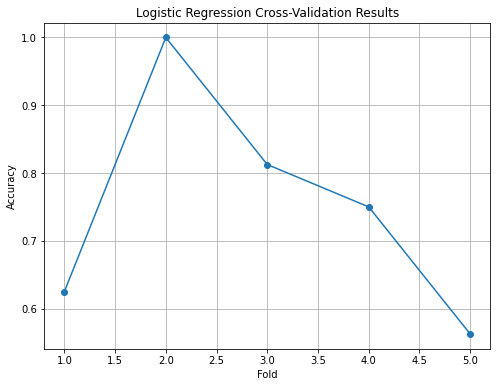

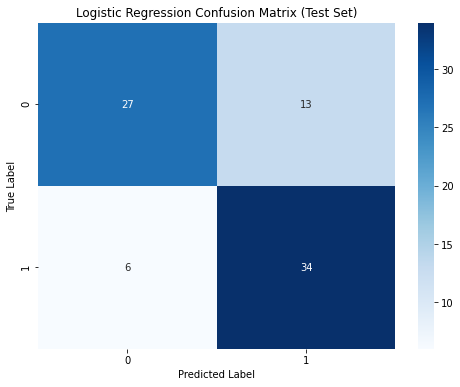

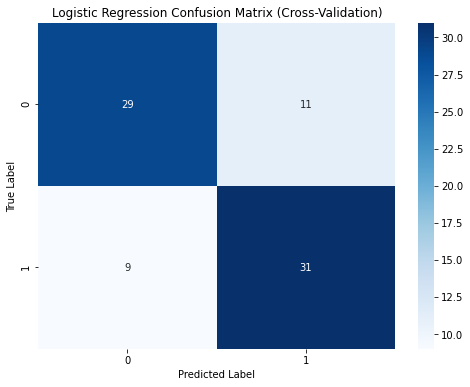

Classifiers:  33%|███▎      | 1/3 [00:08<00:17,  8.59s/it]

Random Forest Accuracy: 0.7125


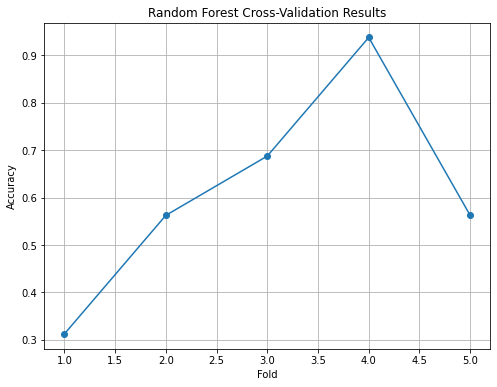

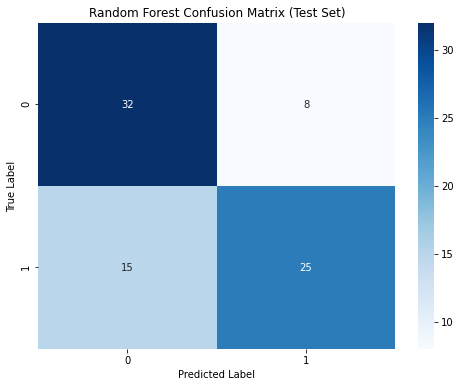

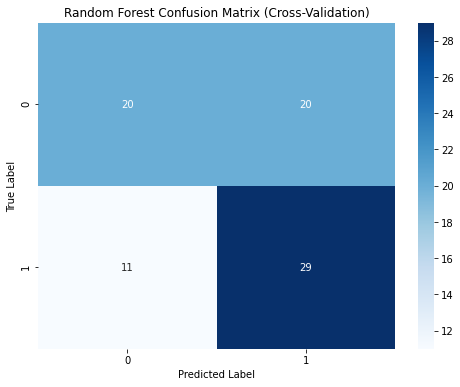

Classifiers:  67%|██████▋   | 2/3 [00:15<00:07,  7.33s/it]

Gradient Boosting Accuracy: 0.6875


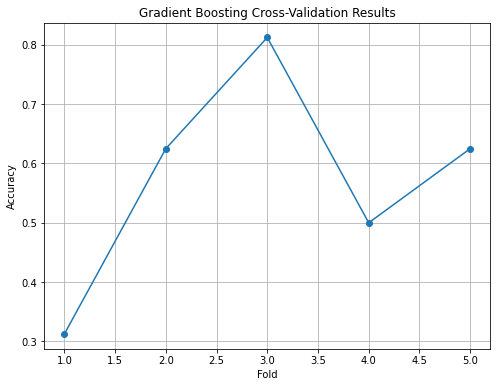

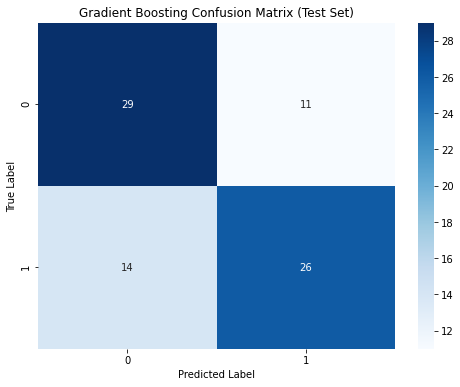

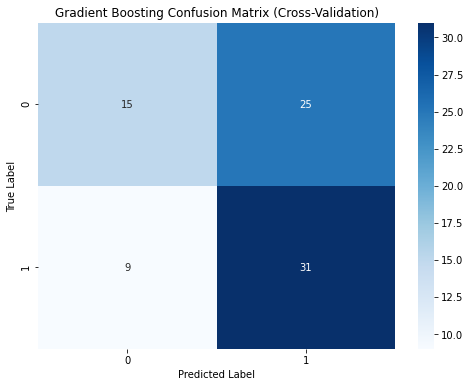

Classifiers: 100%|██████████| 3/3 [13:20<00:00, 266.78s/it]


for data in post condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  194088  triggers
sampling frequency is  256
Length of data set is  194088
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  197343  triggers
sampling frequency is  256
Length of data set is  197343
----- ready to run ML for P-1 at post-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.5


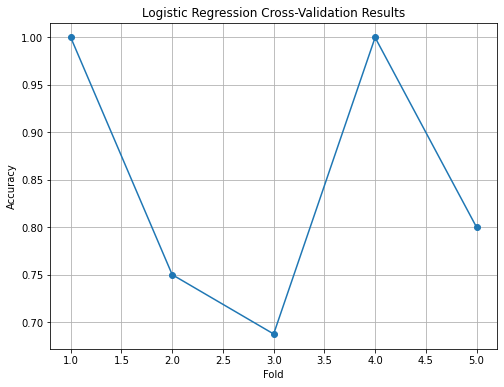

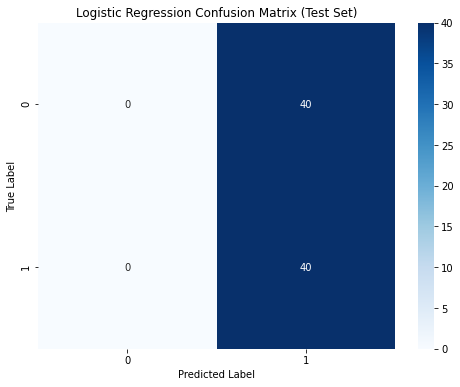

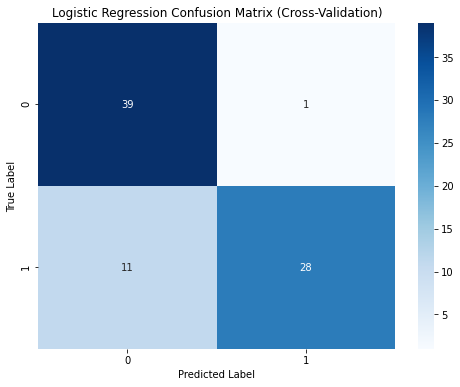

Classifiers:  33%|███▎      | 1/3 [00:09<00:18,  9.29s/it]

Random Forest Accuracy: 0.5875


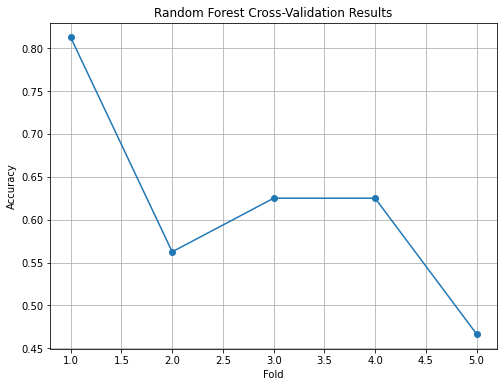

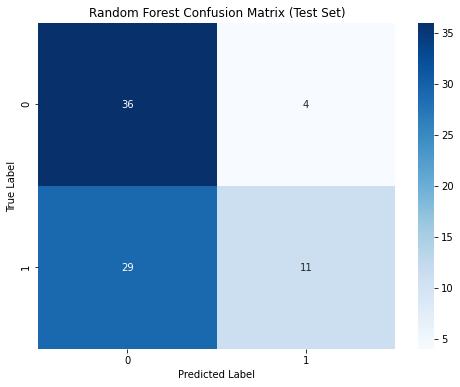

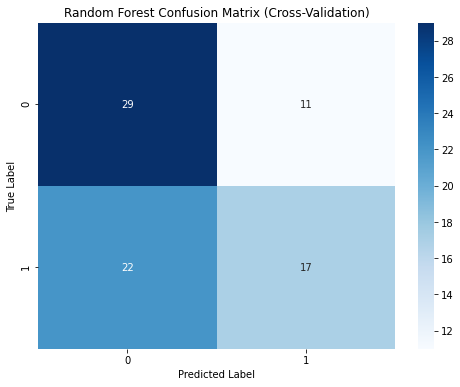

Classifiers:  67%|██████▋   | 2/3 [00:15<00:07,  7.54s/it]

Gradient Boosting Accuracy: 0.5125


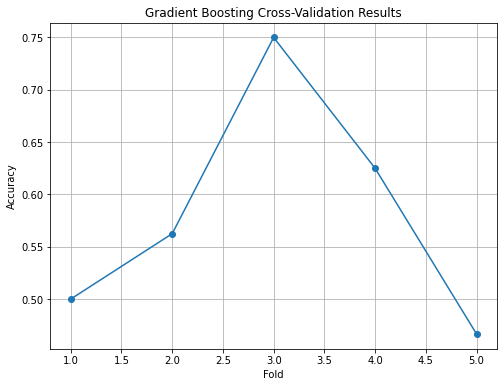

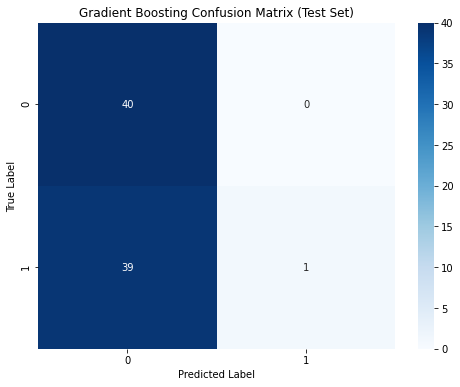

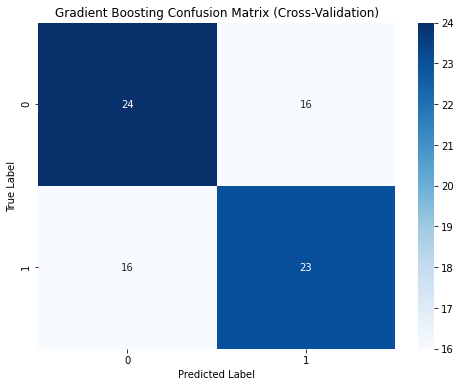

Classifiers: 100%|██████████| 3/3 [12:55<00:00, 258.47s/it]


===============P-2 Data Running===============
for data in pre condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  199552  triggers
sampling frequency is  256
Length of data set is  199552
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  223112  triggers
sampling frequency is  256
Length of data set is  223112
----- ready to run ML for P-2 at pre-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.6625


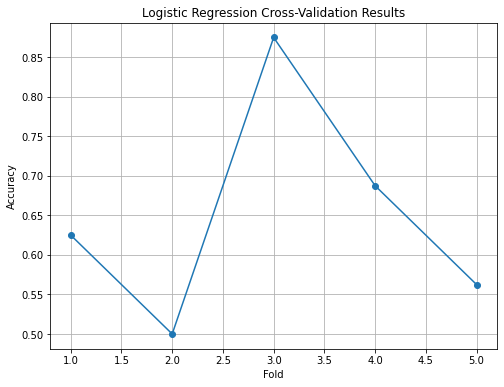

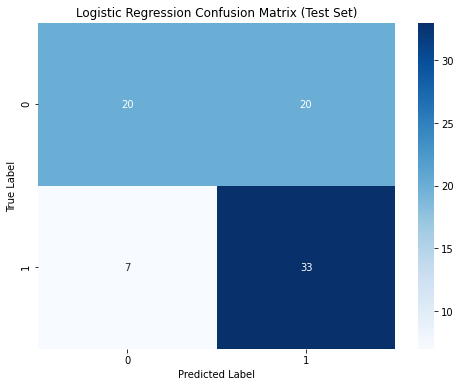

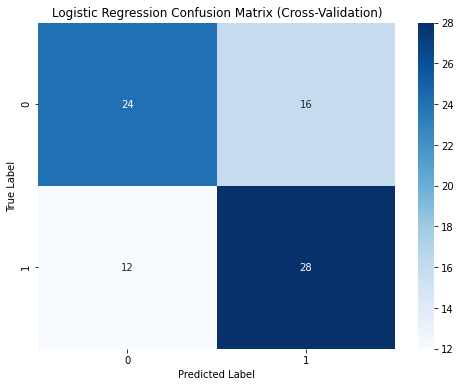

Classifiers:  33%|███▎      | 1/3 [00:08<00:16,  8.03s/it]

Random Forest Accuracy: 0.5875


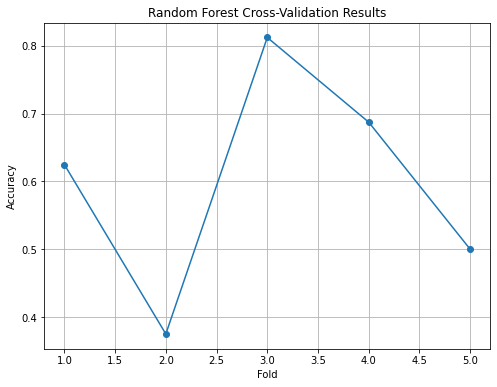

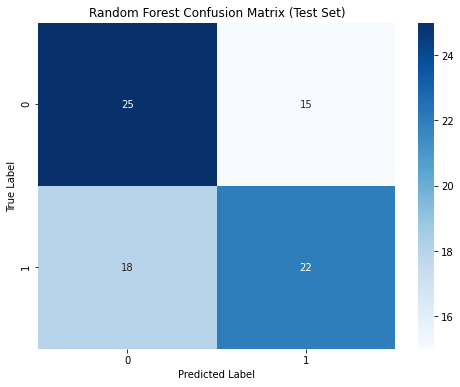

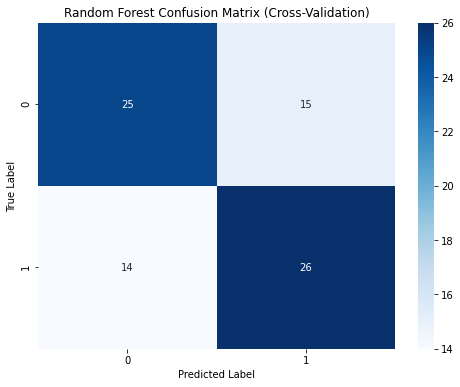

Classifiers:  67%|██████▋   | 2/3 [00:14<00:07,  7.02s/it]

Gradient Boosting Accuracy: 0.6375


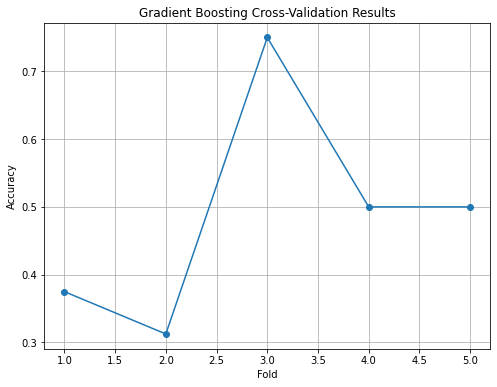

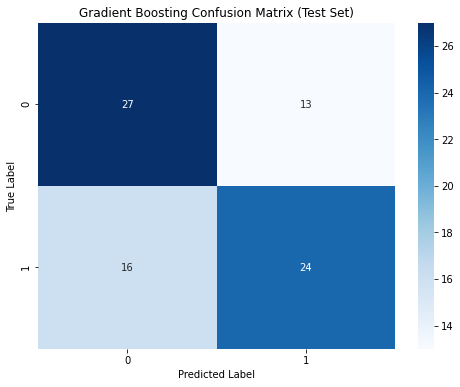

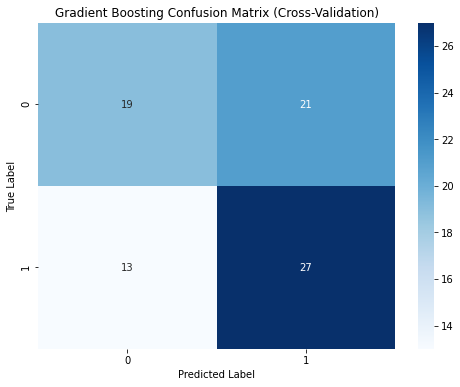

Classifiers: 100%|██████████| 3/3 [14:23<00:00, 287.99s/it]


for data in post condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  233576  triggers
sampling frequency is  256
Length of data set is  233576
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  216720  triggers
sampling frequency is  256
Length of data set is  216720
----- ready to run ML for P-2 at post-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.65


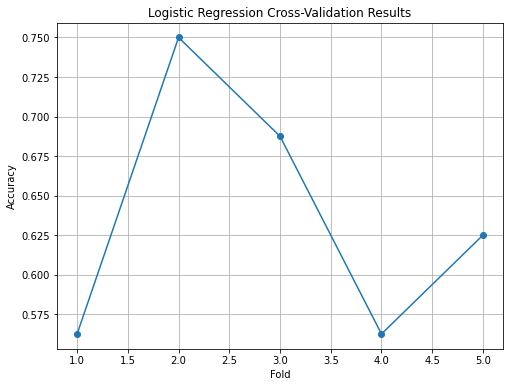

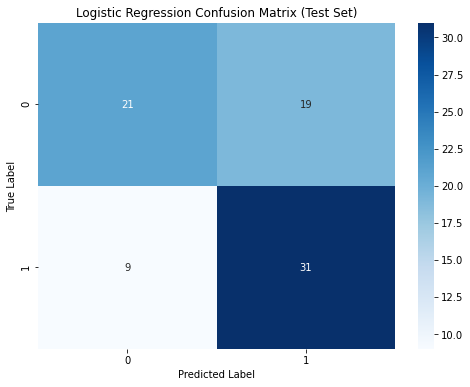

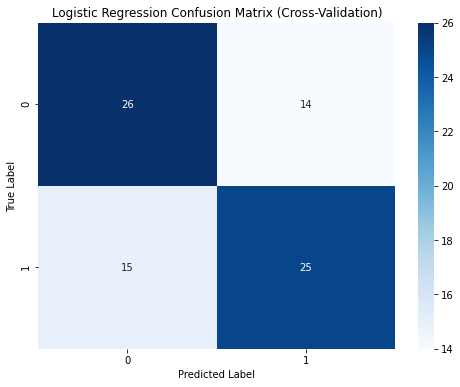

Classifiers:  33%|███▎      | 1/3 [00:06<00:12,  6.14s/it]

Random Forest Accuracy: 0.7375


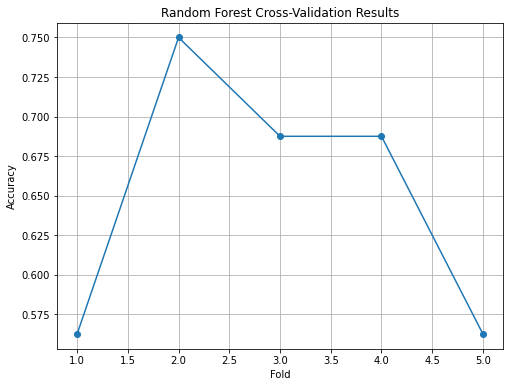

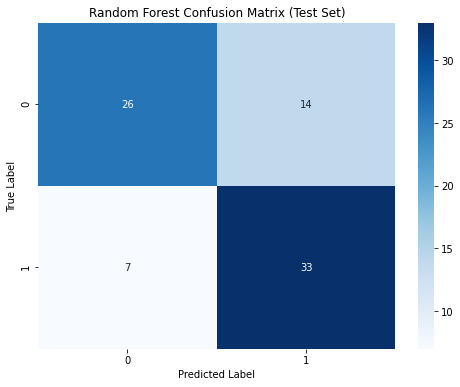

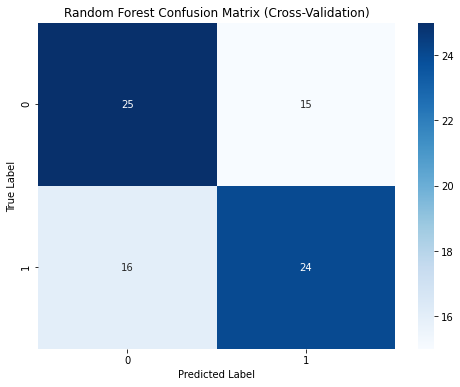

Classifiers:  67%|██████▋   | 2/3 [00:12<00:06,  6.06s/it]

Gradient Boosting Accuracy: 0.65


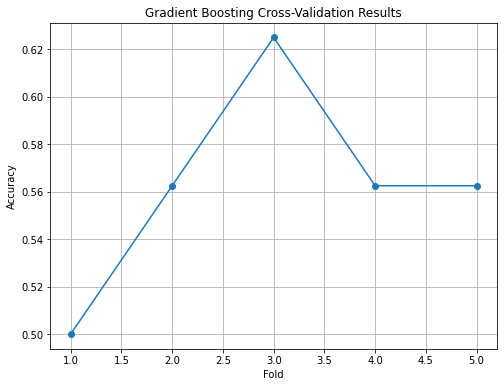

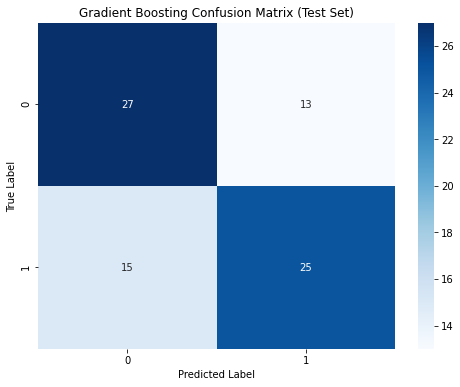

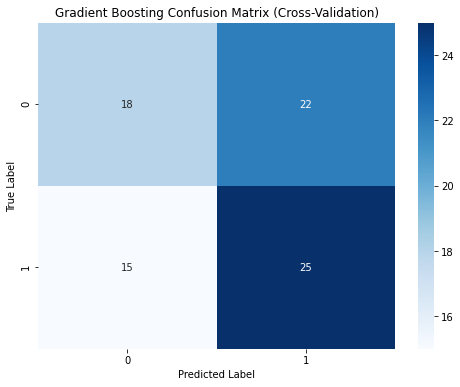

Classifiers: 100%|██████████| 3/3 [13:23<00:00, 267.94s/it]


===============P-3 Data Running===============
for data in pre condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  248488  triggers
sampling frequency is  256
Length of data set is  248488
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  205536  triggers
sampling frequency is  256
Length of data set is  205536
----- ready to run ML for P-3 at pre-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.6075949367088608


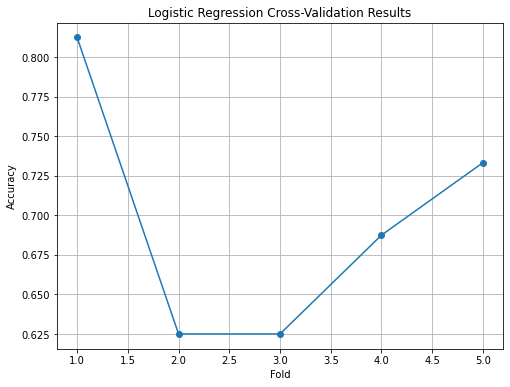

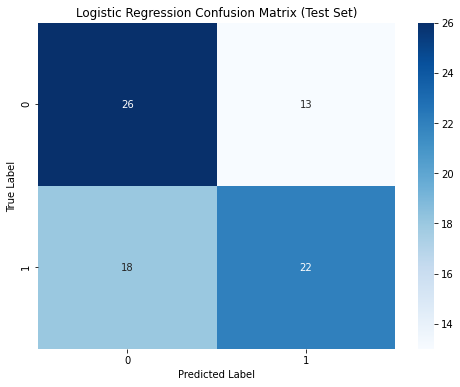

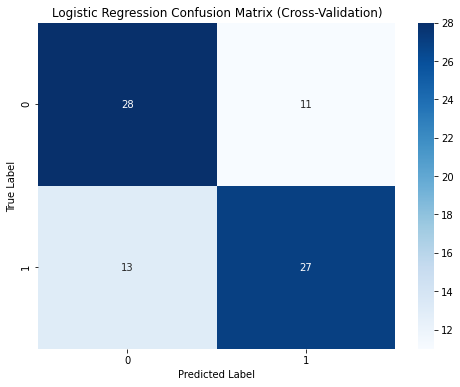

Classifiers:  33%|███▎      | 1/3 [00:06<00:13,  6.71s/it]

Random Forest Accuracy: 0.6329113924050633


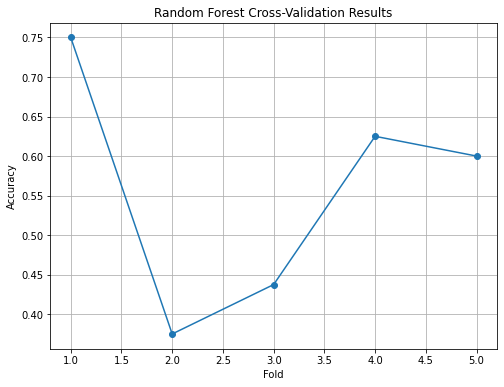

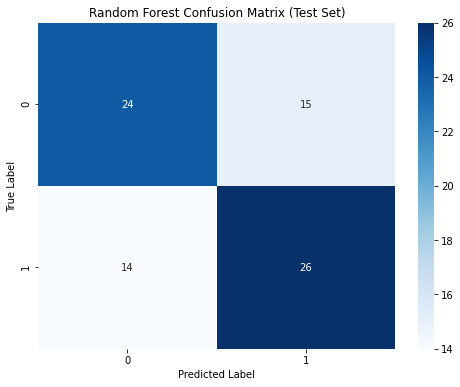

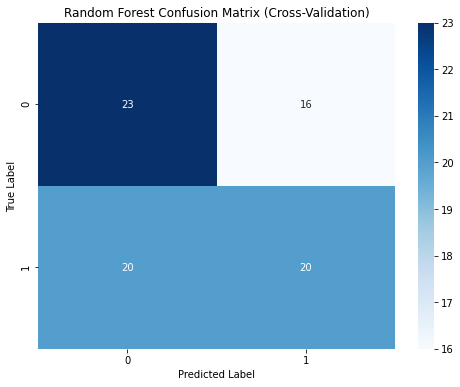

Classifiers:  67%|██████▋   | 2/3 [00:12<00:06,  6.32s/it]

Gradient Boosting Accuracy: 0.569620253164557


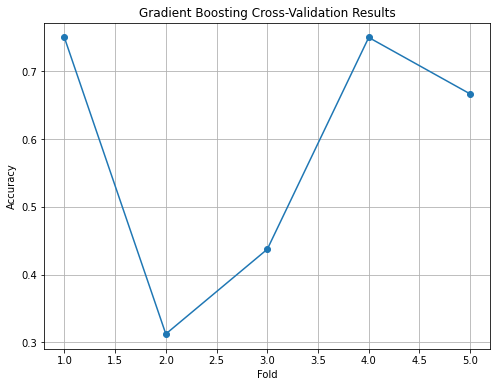

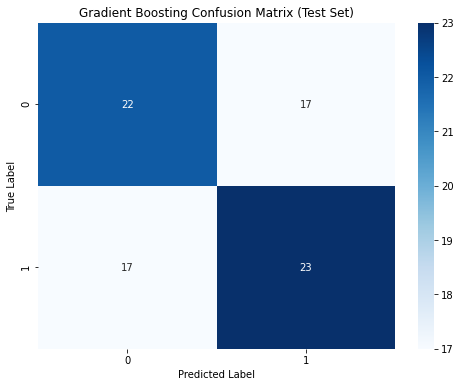

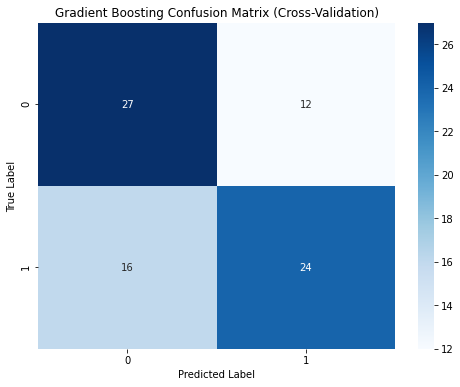

Classifiers: 100%|██████████| 3/3 [12:38<00:00, 252.94s/it]


for data in post condition
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  218432  triggers
sampling frequency is  256
Length of data set is  218432
The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  206504  triggers
sampling frequency is  256
Length of data set is  206504
----- ready to run ML for P-3 at post-----


Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.6


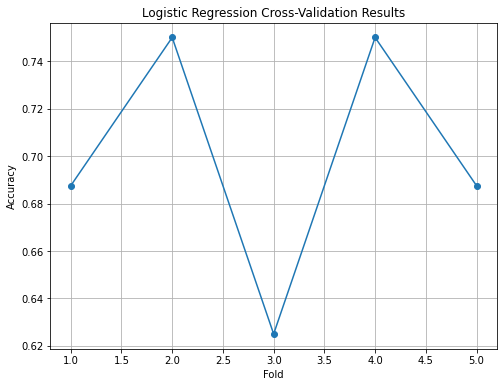

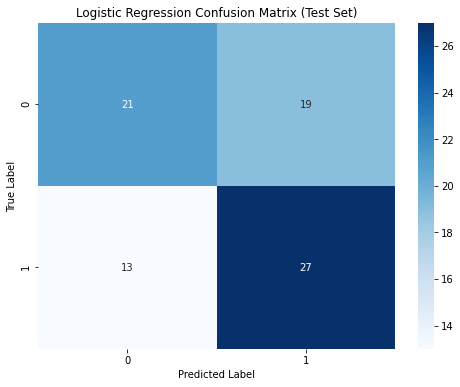

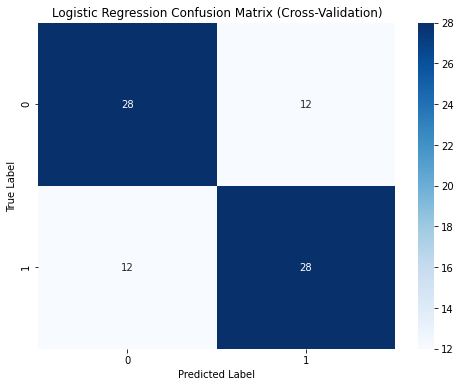

Classifiers:  33%|███▎      | 1/3 [00:07<00:14,  7.06s/it]

Random Forest Accuracy: 0.6125


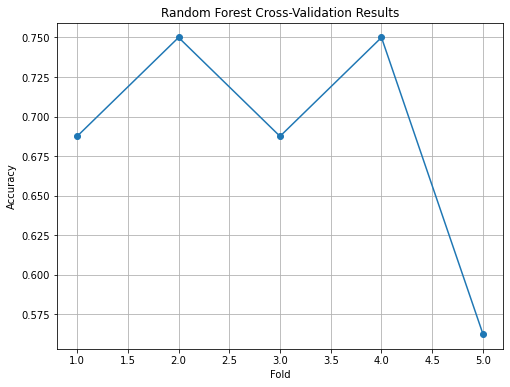

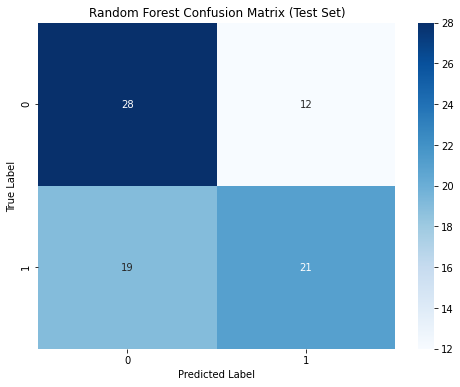

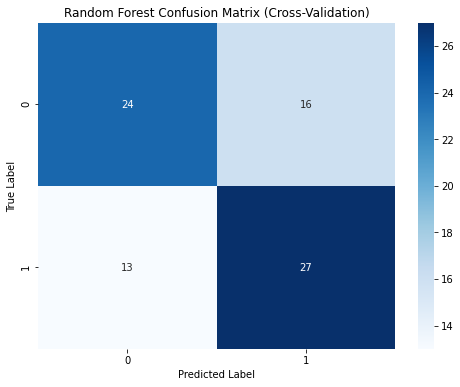

Classifiers:  67%|██████▋   | 2/3 [00:13<00:06,  6.43s/it]

Gradient Boosting Accuracy: 0.5125


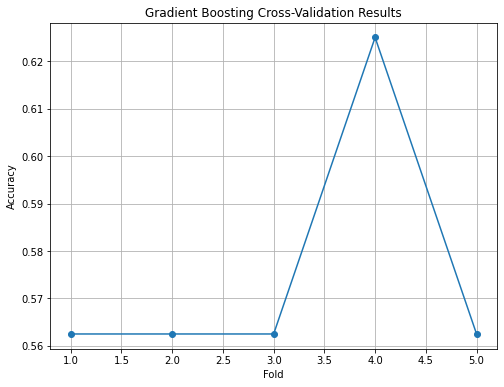

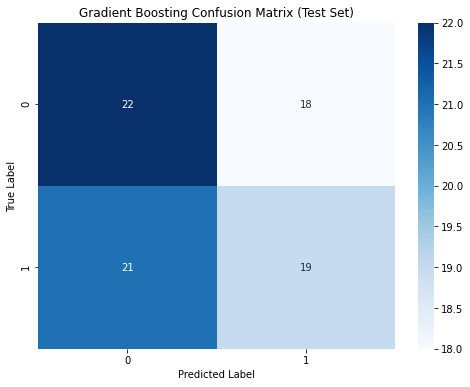

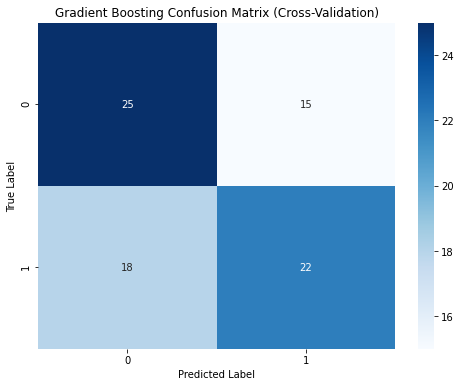

Classifiers: 100%|██████████| 3/3 [13:30<00:00, 270.26s/it]


In [44]:
for sub in range(1,4):
    print(f'===============P-{sub} Data Running===============')
    for con in ['pre','post']:
        print(f'for data in {con} condition')

        path_training = os.path.join(stroke_path,f'P{sub}_{con}_training.mat')
        path_test = os.path.join(stroke_path,f'P{sub}_{con}_test.mat')
        train_mat = spio.loadmat(path_training, squeeze_me=True)
        test_mat = spio.loadmat(path_test, squeeze_me=True)

        test_triggers, test_fs, test_eeg = describe_organise_data(test_mat)
        train_triggers, train_fs, train_eeg = describe_organise_data(train_mat)

        train_data, train_labels =format_data(train_triggers, train_fs, train_eeg)
        test_data, test_labels = format_data(test_triggers, test_fs, test_eeg )

        train_data_2D = train_data.reshape(train_data.shape[0], train_data.shape[1] * train_data.shape[2])
        test_data_2D = test_data.reshape(test_data.shape[0], test_data.shape[1] * test_data.shape[2])

        print(f'----- ready to run ML for P-{sub} at {con}-----')

        trad_ML_training(sub, con, classifiers, train_data_2D, test_data_2D, train_labels, test_labels, 5)
    

# Statistical Test- ANOVA

In [ ]:
from scipy.stats import f_oneway

In [153]:
all_cv_result = {
    'pre': {
        "Logistic Regression": {},
        "Random Forest": {},
        "Gradient Boosting": {}
    },
    'post': {
        "Logistic Regression": {},
        "Random Forest": {},
        "Gradient Boosting": {}
    }
}

In [155]:
for con in all_cv_result.keys():
    for method in all_cv_result[con].keys():
        concat_list = []
        for sub in range(1, 4):
            cv_result_df = pd.read_csv(f'P{sub}_{con}_{method}_cross_validation_results.csv', index_col=0)
            concat_list.append(cv_result_df)
        all_cv_result_df = pd.concat(concat_list, axis=1)
        all_cv_result_df.columns = ['P1', 'P2', 'P3']
        all_cv_result[con][method] = all_cv_result_df

In [156]:
concatenated_results = {}
for con in all_cv_result.keys():
    for method in all_cv_result[con].keys():
        concat_list = []
        for sub in range(1, 4):
            cv_result_df = pd.read_csv(f'P{sub}_{con}_{method}_cross_validation_results.csv', index_col=0)
            concat_list.append(cv_result_df)
        concatenated_df = pd.concat(concat_list, axis=1)
        concatenated_df.columns = ['P1', 'P2', 'P3']
        if method not in concatenated_results:
            concatenated_results[method] = {}
        concatenated_results[method][con] = concatenated_df

In [157]:
# Three-way ANOVA
treatments = []
methods = []
subjects = []
accuracies = []

for method, data in concatenated_results.items():
    for treatment, acc in data.items():
        treatment_flat = acc.values.flatten()
        if len(treatment_flat.shape) > 1:  # Check if array is 2D
            raise ValueError("2D array found. Flatten the array before appending.")
        treatment_flat = treatment_flat.tolist()  # Convert NumPy array to list
        accuracies.extend(treatment_flat)
        subjects.extend(['P1'] * int(len(treatment_flat) / 3) + ['P2'] * int(len(treatment_flat) / 3) + ['P3'] * int(len(treatment_flat) / 3))
        treatments.extend([treatment] * len(treatment_flat))
        methods.extend([method] * len(treatment_flat))

In [158]:
# Create DataFrame for ANOVA
df = pd.DataFrame({'Accuracy': accuracies,
                    'Method': methods,
                    'Subject': subjects,
                    'Treatment': treatments})

# Perform three-way ANOVA
formula = 'Accuracy ~ C(Method) + C(Subject) + C(Treatment) + C(Method):C(Subject) + C(Method):C(Treatment) + C(Subject):C(Treatment) + C(Method):C(Subject):C(Treatment)'
model = ols(formula, df).fit()
anova_table = anova_lm(model, typ=3)

# Print ANOVA results
print(f"ANOVA Results for {method}:")
print(anova_table)

ANOVA Results for Gradient Boosting:
                                     sum_sq    df          F        PR(>F)
Intercept                          1.444531   1.0  75.775621  7.407287e-13
C(Method)                          0.116146   2.0   3.046325  5.370370e-02
C(Subject)                         0.021294   2.0   0.558508  5.745202e-01
C(Treatment)                       0.009766   1.0   0.512274  4.764708e-01
C(Method):C(Subject)               0.016647   4.0   0.218317  9.274157e-01
C(Method):C(Treatment)             0.017448   2.0   0.457632  6.346082e-01
C(Subject):C(Treatment)            0.022042   2.0   0.578119  5.635350e-01
C(Method):C(Subject):C(Treatment)  0.025404   4.0   0.333148  8.547942e-01
Residual                           1.372556  72.0        NaN           NaN


In [140]:
concatenated_results = {}
for con in all_cv_result.keys():
    for method in all_cv_result[con].keys():
        concat_list = []
        for sub in range(1, 4):
            cv_result_df = pd.read_csv(f'P{sub}_{con}_{method}_cross_validation_results.csv', index_col=0)
            concat_list.append(cv_result_df)
        concatenated_df = pd.concat(concat_list, axis=1)
        concatenated_df.columns = ['P1', 'P2', 'P3']
        if method not in concatenated_results:
            concatenated_results[method] = {}
        concatenated_results[method][con] = concatenated_df
        
# Three-way ANOVA
treatments = []
methods = []
subjects = []
accuracies = []

for method, data in concatenated_results.items():
    for treatment, acc in data.items():
        treatment_flat = acc.values.flatten()
        if len(treatment_flat.shape) > 1:  # Check if array is 2D
            raise ValueError("2D array found. Flatten the array before appending.")
        treatment_flat = treatment_flat.tolist()  # Convert NumPy array to list
        accuracies.extend(treatment_flat)
        subjects.extend(['P1'] * int(len(treatment_flat) / 3) + ['P2'] * int(len(treatment_flat) / 3) + ['P3'] * int(len(treatment_flat) / 3))
        treatments.extend([treatment] * len(treatment_flat))
        methods.extend([method] * len(treatment_flat))
        
# Create DataFrame for ANOVA
df = pd.DataFrame({'Accuracy': accuracies,
                    'Method': methods,
                    'Subject': subjects,
                    'Treatment': treatments})

# Create DataFrame for ANOVA
df = pd.DataFrame({'Accuracy': accuracies,
                    'Method': methods,
                    'Subject': subjects,
                    'Treatment': treatments})

# Perform three-way ANOVA
formula = 'Accuracy ~ C(Method) + C(Subject) + C(Treatment) + C(Method):C(Subject) + C(Method):C(Treatment) + C(Subject):C(Treatment) + C(Method):C(Subject):C(Treatment)'
model = ols(formula, df).fit()
anova_table = anova_lm(model, typ=3)

# Print ANOVA results
print(f"ANOVA Results for {method}:")
print(anova_table)

In [159]:
# Create DataFrame for ANOVA
df = pd.DataFrame({'Accuracy': accuracies,
                    'Method': methods,
                    'Subject': subjects,
                    'Treatment': treatments})

# Perform three-way ANOVA
formula = 'Accuracy ~ C(Method) + C(Subject) + C(Treatment) + C(Method):C(Subject) + C(Method):C(Treatment) + C(Subject):C(Treatment) + C(Method):C(Subject):C(Treatment)'
model = ols(formula, df).fit()
anova_table = anova_lm(model, typ=3)

# Print ANOVA results
print(f"ANOVA Results for {method}:")
print(anova_table)


ANOVA Results for Gradient Boosting:
                                     sum_sq    df          F        PR(>F)
Intercept                          1.444531   1.0  75.775621  7.407287e-13
C(Method)                          0.116146   2.0   3.046325  5.370370e-02
C(Subject)                         0.021294   2.0   0.558508  5.745202e-01
C(Treatment)                       0.009766   1.0   0.512274  4.764708e-01
C(Method):C(Subject)               0.016647   4.0   0.218317  9.274157e-01
C(Method):C(Treatment)             0.017448   2.0   0.457632  6.346082e-01
C(Subject):C(Treatment)            0.022042   2.0   0.578119  5.635350e-01
C(Method):C(Subject):C(Treatment)  0.025404   4.0   0.333148  8.547942e-01
Residual                           1.372556  72.0        NaN           NaN


## Visualization by Subjects (P1, P2, P3) 

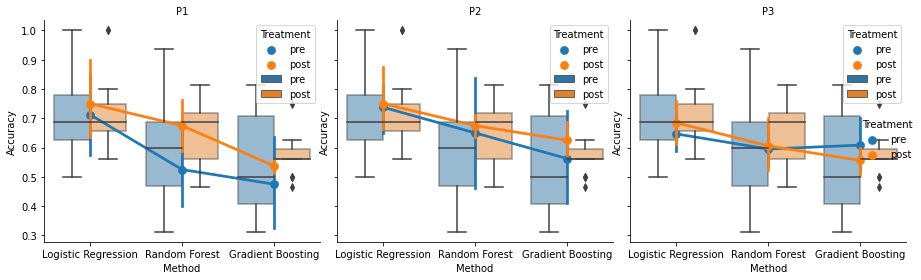

In [160]:
# Plot interaction graphs with boxplots
interaction_plots = sns.catplot(x='Method', y='Accuracy', hue='Treatment', col='Subject', kind='point', data=df, height=4, aspect=1)
interaction_plots.set_axis_labels('Method', 'Accuracy')
interaction_plots.set_titles('{col_name}')
plt.tight_layout()

# Add boxplots
for ax in interaction_plots.axes.flat:
    sns.boxplot(x='Method', y='Accuracy', hue='Treatment', data=df, ax=ax, dodge=True, boxprops=dict(alpha=0.5))

plt.show()


## Visualization by Treatment (Pre-, Post-)

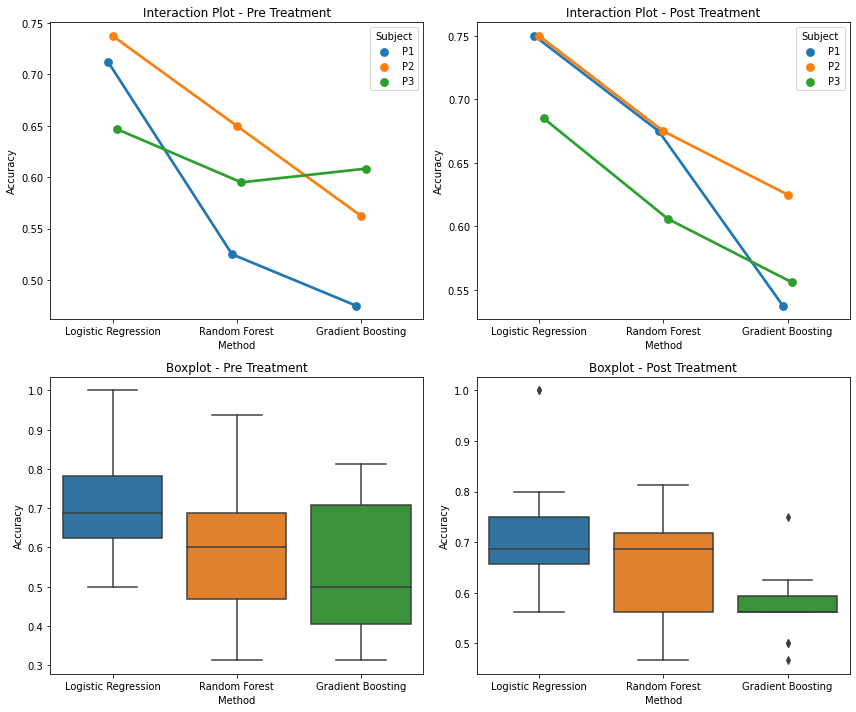

In [161]:
# Plotting interaction plots
fig, axes_interaction = plt.subplots(2, 2, figsize=(12, 10))

# Plot interaction plot for pre treatment
sns.pointplot(x='Method', y='Accuracy', hue='Subject', data=df[df['Treatment'] == 'pre'], ax=axes_interaction[0, 0], dodge=True, ci=None)
axes_interaction[0, 0].set_title('Interaction Plot - Pre Treatment')
axes_interaction[0, 0].set_xlabel('Method')
axes_interaction[0, 0].set_ylabel('Accuracy')

# Plot interaction plot for post treatment
sns.pointplot(x='Method', y='Accuracy', hue='Subject', data=df[df['Treatment'] == 'post'], ax=axes_interaction[0, 1], dodge=True, ci=None)
axes_interaction[0, 1].set_title('Interaction Plot - Post Treatment')
axes_interaction[0, 1].set_xlabel('Method')
axes_interaction[0, 1].set_ylabel('Accuracy')

# Plotting boxplots
# Boxplot for pre treatment
sns.boxplot(x='Method', y='Accuracy', data=df[df['Treatment'] == 'pre'], ax=axes_interaction[1, 0])
axes_interaction[1, 0].set_title('Boxplot - Pre Treatment')
axes_interaction[1, 0].set_xlabel('Method')
axes_interaction[1, 0].set_ylabel('Accuracy')

# Boxplot for post treatment
sns.boxplot(x='Method', y='Accuracy', data=df[df['Treatment'] == 'post'], ax=axes_interaction[1, 1])
axes_interaction[1, 1].set_title('Boxplot - Post Treatment')
axes_interaction[1, 1].set_xlabel('Method')
axes_interaction[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()
